Reference: https://www.kaggle.com/code/vencerlanz09/plant-stress-classification-using-cnn-mobilenet

In [5]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns



Directory

In [6]:
dataset = "Resized_Dataset"
mobilenet_train_dir = 'Resized_Dataset/train'
mobilenet_test_dir = 'Resized_Dataset/test'

In [25]:
# Function to count the number of images in each subfolder
def count_images_in_folders(dataset):
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.tif', '.webp', '.heic', '.svg')
    folder_counts = {}
    for folder_name in os.listdir(dataset):
        folder_path = os.path.join(dataset, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([file for file in os.listdir(folder_path) if file.lower().endswith(image_extensions)])
            folder_counts[folder_name] = num_images
    return folder_counts

# Get the count of images in each folder
image_counts = count_images_in_folders(mobilenet_train_dir)
print(image_counts)

{'Apple_Healthy': 1950, 'Apple_Rotten': 2339}


View Images

In [7]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
image_df

,Filepath,Label
0,Resized_Dataset\test\Apple_Healthy\FreshApple ...,Apple_Healthy
1,Resized_Dataset\test\Apple_Healthy\FreshApple ...,Apple_Healthy
2,Resized_Dataset\test\Apple_Healthy\FreshApple ...,Apple_Healthy
3,Resized_Dataset\test\Apple_Healthy\FreshApple ...,Apple_Healthy
4,Resized_Dataset\test\Apple_Healthy\FreshApple ...,Apple_Healthy
...,...,...
10715,Resized_Dataset\train\Apple_Rotten\vertical_fl...,Apple_Rotten
10716,Resized_Dataset\train\Apple_Rotten\vertical_fl...,Apple_Rotten
10717,Resized_Dataset\train\Apple_Rotten\vertical_fl...,Apple_Rotten
10718,Resized_Dataset\train\Apple_Rotten\vertical_fl...,Apple_Rotten


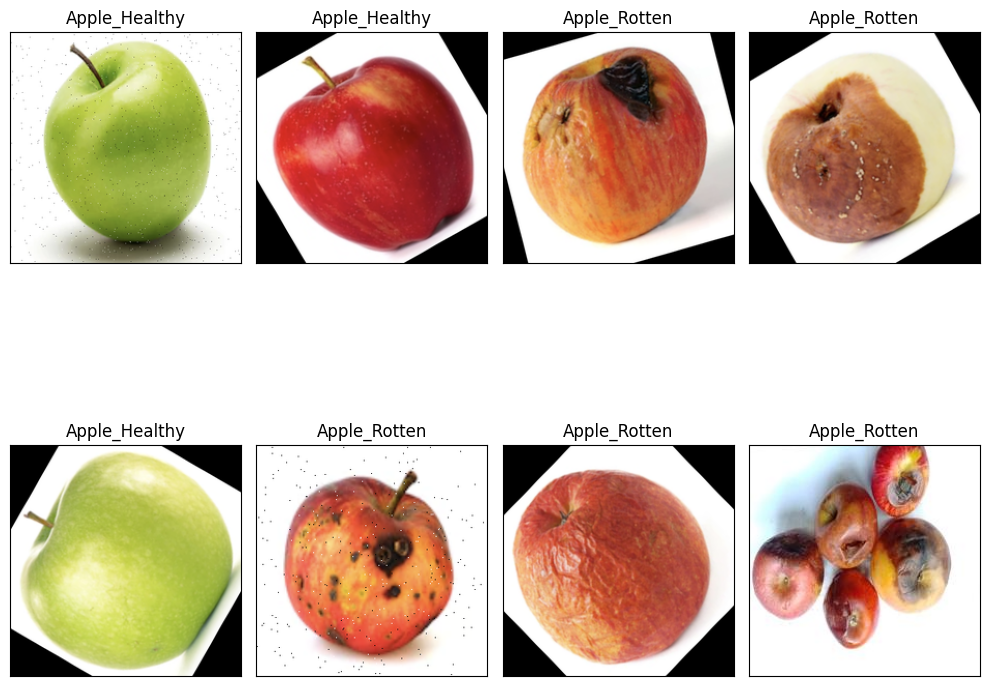

In [9]:
# Display 8 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

Base Model MobileNetv3

In [10]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Create ImageDataGenerator for training and testing
mobilenet_train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2  # a subset of training data for validation
)

mobilenet_test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [11]:
# Training Set (80%)
mobilenet_train_images = mobilenet_train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Validation Set (20%)
mobilenet_val_images = mobilenet_train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test Set
mobilenet_test_images = mobilenet_test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 6861 validated image filenames belonging to 2 classes.
Found 1715 validated image filenames belonging to 2 classes.
Found 2144 validated image filenames belonging to 2 classes.


In [12]:
# Load the MobileNetV3Large model with pre-trained ImageNet weights, excluding the top layers
mobilenet_pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

mobilenet_pretrained_model.trainable = False

# Create the new model with added regularization
mobilenet_inputs = mobilenet_pretrained_model.input
mobilenet_x = mobilenet_pretrained_model.output
mobilenet_x = layers.GlobalAveragePooling2D()(mobilenet_x)
mobilenet_x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(mobilenet_x)
mobilenet_x = layers.Dropout(0.5)(mobilenet_x)
mobilenet_x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(mobilenet_x)
mobilenet_x = layers.Dropout(0.5)(mobilenet_x)
mobilenet_outputs = layers.Dense(1, activation='sigmoid')(mobilenet_x)

model = Model(inputs=mobilenet_inputs, outputs=mobilenet_outputs)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Display the model summary
model.summary()


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 16)      │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 112, 112, 16)      │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 16)      │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, 112, 112, 16)      │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, 112, 112, 64)      │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, 112, 112, 64)      │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 112, 112, 64)      │               

 Total params: 3,275,393 (12.49 MB)

 Trainable params: 279,041 (1.06 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [13]:
# Checkpoint callback
checkpoint_path = "MobileNet.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True)

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    mobilenet_train_images,
    validation_data=mobilenet_val_images,
    epochs=10,
    callbacks=[early_stopping, checkpoint_callback]
)


Epoch 1/10


C:\Users\user\anaconda3\envs\CDS6334\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 43s 178ms/step - accuracy: 0.8541 - loss: 0.8492 - val_accuracy: 0.9784 - val_loss: 0.4586
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.9825 - loss: 0.4266 - val_accuracy: 0.9895 - val_loss: 0.3286
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.9922 - loss: 0.3153 - val_accuracy: 0.9942 - val_loss: 0.2541
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 167ms/step - accuracy: 0.9910 - loss: 0.2434 - val_accuracy: 0.9889 - val_loss: 0.2251
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 175ms/step - accuracy: 0.9956 - loss: 0.1951 - val_accuracy: 0.9959 - val_loss: 0.1689
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - accuracy: 0.9943 - loss: 0.1607 - val_accuracy: 0.9983 - val_loss: 0.1413
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - accuracy: 0.9987 - loss: 0.1297 - val_accuracy: 0.9953 - val_loss: 0.1302
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.9963 - loss: 0.1148 - val

In [31]:
# Store training loss from history
mobilenet_training_loss = history.history['loss']
mobilenet_training_acc = history.history['accuracy']

# Print the stored value (optional)
print(f"Training Loss: {mobilenet_training_loss}")
print(f"Training Accuracy: {mobilenet_training_acc}")

Training Loss: [0.6613829731941223, 0.4012534022331238, 0.2947980463504791, 0.23131676018238068, 0.18556399643421173, 0.1542213410139084, 0.1257689744234085, 0.10862978547811508, 0.08862125128507614, 0.07840877026319504]
Training Accuracy: [0.9245008230209351, 0.9819268584251404, 0.9922751784324646, 0.9928581714630127, 0.995773196220398, 0.995044469833374, 0.9976679682731628, 0.9976679682731628, 0.9983967542648315, 0.9973765015602112]


In [19]:
# Evaluate model on test set
test_loss, mobilenet_test_accuracy = model.evaluate(mobilenet_test_images)
print(f"Test accuracy: {mobilenet_test_accuracy:.4f}")

# Predict classes
mobilenet_test_images.reset() # Reset Generator
mobilenet_pred = model.predict(mobilenet_test_images) # Predicted probabilities
mobilenet_pred = np.round(mobilenet_pred).astype(int) # Probabilities to binary prediction
mobilenet_labels = mobilenet_test_images.classes # True labels

target_names = list(mobilenet_test_images.class_indices.keys())
mobilenet_report = classification_report(mobilenet_labels, mobilenet_pred, target_names=target_names, digits=4)
print("Classification Report:\n", mobilenet_report)

67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9960 - loss: 0.0846
Test accuracy: 0.9981
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step
Classification Report:
                precision    recall  f1-score   support

Apple_Healthy     0.9959    1.0000    0.9980       974
 Apple_Rotten     1.0000    0.9966    0.9983      1170

     accuracy                         0.9981      2144
    macro avg     0.9980    0.9983    0.9981      2144
 weighted avg     0.9981    0.9981    0.9981      2144



In [32]:
%store mobilenet_training_loss
%store mobilenet_training_acc

Stored 'mobilenet_training_loss' (list)
Stored 'mobilenet_training_acc' (list)


In [18]:
%store mobilenet_report

Stored 'mobilenet_report' (str)


In [20]:
%store mobilenet_test_accuracy

Stored 'mobilenet_test_accuracy' (float)


Confusion Matrix:
 [[ 974    0]
 [   4 1166]]


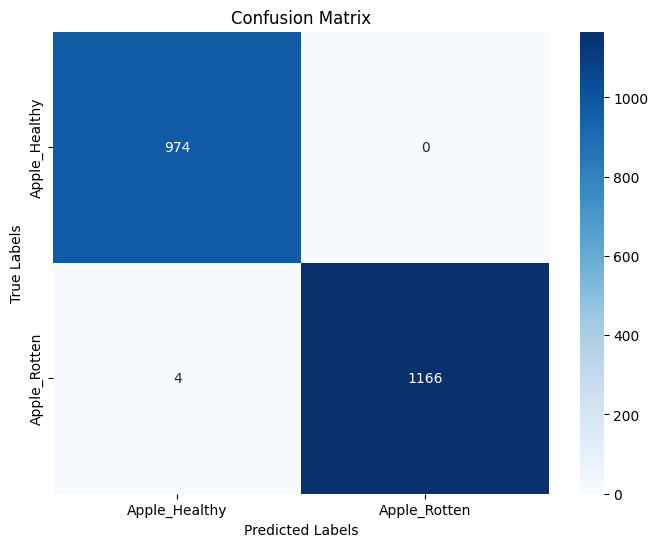

In [16]:
mobilenet_conf_matrix = confusion_matrix(mobilenet_labels, mobilenet_pred)
print("Confusion Matrix:\n", mobilenet_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(mobilenet_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

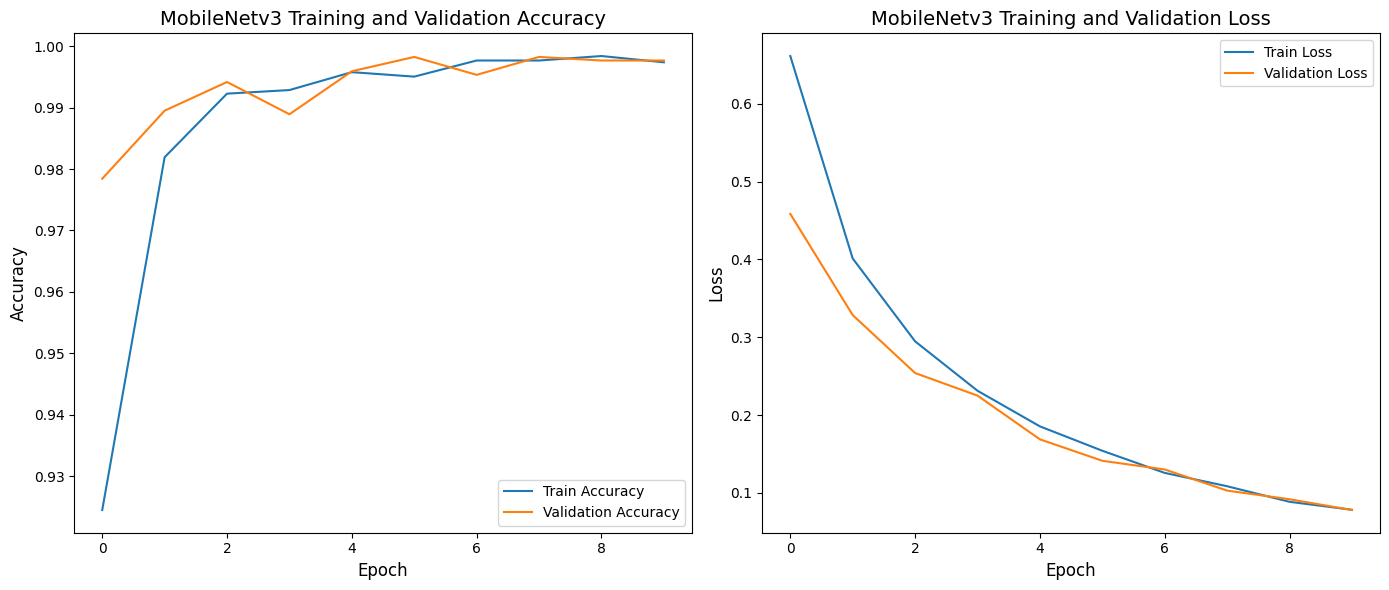

In [17]:
plt.figure(figsize=(14, 6))

# Training and Validation Accuracy and Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('MobileNetv3 Training and Validation Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10)

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MobileNetv3 Training and Validation Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

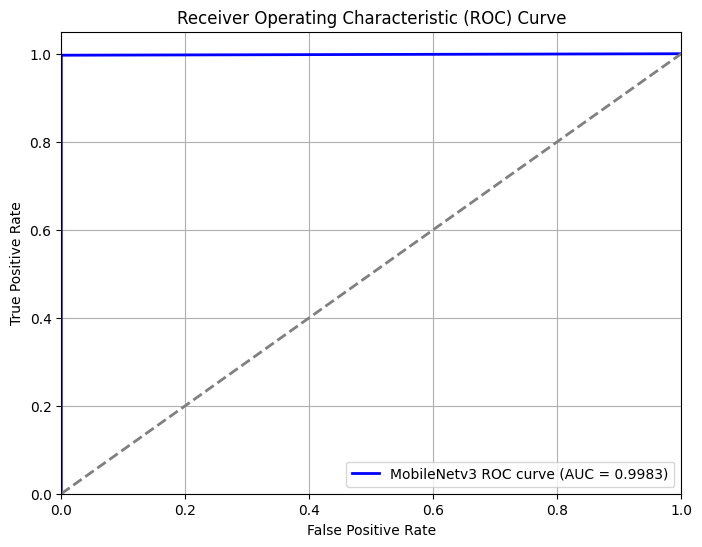

In [43]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(mobilenet_labels, mobilenet_pred)
mobilenet_auc_score = roc_auc_score(mobilenet_labels, mobilenet_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'MobileNetv3 ROC curve (AUC = {mobilenet_auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [44]:
%store mobilenet_auc_score

Stored 'mobilenet_auc_score' (float64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_14524\616212949.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_label = class_labels[int(np.round(prediction))]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


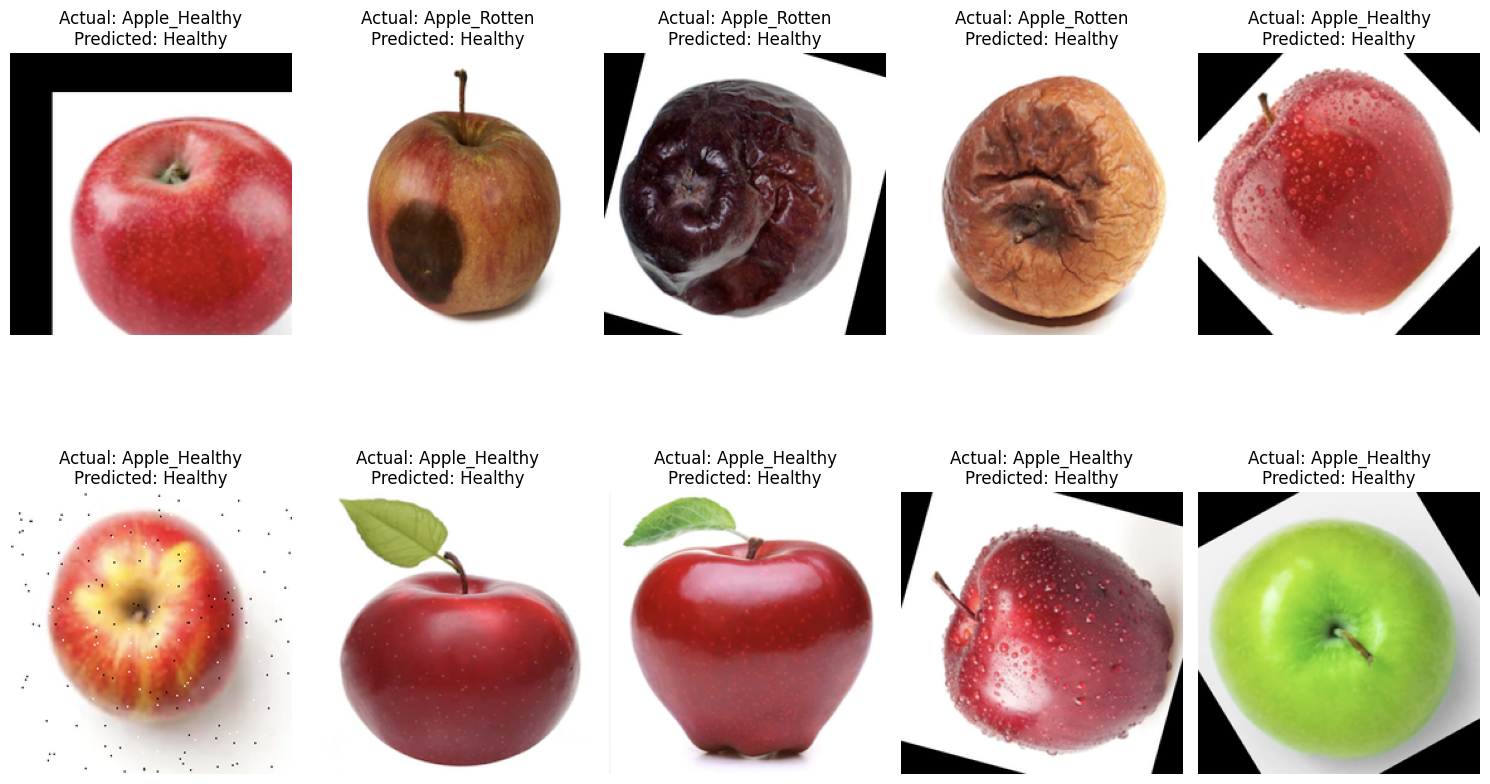

In [42]:
# Function to predict with a random image
def predict_random_images(model, test_dir, class_labels, num_images=10):
    # Get class directories
    class_dirs = os.listdir(test_dir)
    
    # Prepare to collect predictions for 10 images
    predictions = []

    for _ in range(num_images):
        # Choose random class directory
        random_class = random.choice(class_dirs)
        class_dir = os.path.join(test_dir, random_class)

        # Get all image files in chosen class directory
        all_images = os.listdir(class_dir)
        # Choose random image file
        random_image = random.choice(all_images)
        random_image_path = os.path.join(class_dir, random_image)

        # Load and preprocess the image
        img = image.load_img(random_image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.  # Rescale to [0, 1]

        # Predict class label
        prediction = model.predict(img_array)
        prediction_label = class_labels[int(np.round(prediction))]

        # Store prediction result
        predictions.append((random_image_path, random_class, prediction_label))

    # Display images and predictions
    fig = plt.figure(figsize=(15, 10))
    for i, (image_path, actual_class, predicted_label) in enumerate(predictions):
        img = image.load_img(image_path, target_size=(224, 224))
        ax = fig.add_subplot(2, 5, i + 1)
        ax.imshow(img)
        ax.set_title(f'Actual: {actual_class}\nPredicted: {predicted_label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
class_labels = ['Healthy', 'Rotten']
predict_random_images(model, mobilenet_test_dir, class_labels, num_images=10)


Overall, MobileNetv3 achieved a remarkably high test accuracy of 99.81%, correctly classifying 99.81% of the test samples. Both the training and validation accuracy curves show a rapid convergence to near 100%, meaning that the model learned the training data well and applied it effectively to the validation data. The validation accuracy closely matches the training accuracy, with minimal fluctuations, confirming stable performance without major overfitting.

Both the training and validation loss curves steadily decrease and close to low values, which suggests that the model is effective at minimising loss on both sets. The model performs well in classifying "Apple_Healthy" and "Apple_Rotten" with near-perfect accuracy, precision, recall, and F1 scores.